In [1]:
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt 
from keras import layers, models, applications, regularizers
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from mtcnn import MTCNN
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, classification_report, auc

2025-07-14 18:19:50.378786: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-14 18:19:50.389307: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-14 18:19:50.480088: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-14 18:19:50.550138: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752527990.620956  254548 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752527990.63

# Checar se tem GPU disponível

In [2]:
print("Num GPUs Disp:", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    try:
        # Ativa a primeira GPU
        tf.config.experimental.set_memory_growth(gpus[0], True)
        tf.config.set_visible_devices(gpus[0], 'GPU')
        device = '/GPU:0'
        print("✅ Usando GPU")
    except RuntimeError as e:
        print("⚠️ Erro ao configurar GPU:", e)
        device = '/CPU:0'
else:
    print("❌ GPU não disponível, usando CPU")
    device = '/CPU:0'

Num GPUs Disp: 0
❌ GPU não disponível, usando CPU


2025-07-14 18:19:55.122488: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


# Criando a estrutura do projeto


In [3]:
IA_path = os.path.join('data','IA') #caminho das imagens geradas por IA
Real_path = os.path.join('data','Real') #caminho das imagens de pessoas reais

#criando pastas
os.makedirs(IA_path, exist_ok=True)
os.makedirs(Real_path, exist_ok=True)

# Pré-Processamento das Imagens e Divisão Train/Test/Val

In [4]:
# --- Constants ---
IMG_SIZE = (50, 50)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

# --- Preprocessing images (central crop + resize) ---
def preprocess(image_path):
    image = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(image, channels=3)
    # image = tf.image.resize_with_crop_or_pad(image, 160, 160)
    # image = tf.image.central_crop(image, central_fraction=0.8)
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32) / 255.0
    return image

# --- Data Augmentation (only for training) ---
def augment(x, y):
    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_brightness(x, 0.2)
    x = tf.image.random_contrast(x, 0.8, 1.2)
    return x, y

# --- Load filepaths separately ---
ia_files = tf.data.Dataset.list_files(os.path.join(IA_path, '*.jpg'), shuffle=True)
real_files = tf.data.Dataset.list_files(os.path.join(Real_path, '*.jpg'), shuffle=True)

# --- Map to (image, label) ---
ia_ds = ia_files.map(lambda x: (preprocess(x), tf.constant(1)), num_parallel_calls=AUTOTUNE)
real_ds = real_files.map(lambda x: (preprocess(x), tf.constant(0)), num_parallel_calls=AUTOTUNE)

# --- Balance classes using sample_from_datasets ---
balanced_ds = tf.data.Dataset.sample_from_datasets([real_ds, ia_ds], weights=[0.5, 0.5])
balanced_ds = balanced_ds.shuffle(500, seed=42)

# --- Split manually ---
total_samples = 160000  
train_size = int(0.7 * total_samples)
val_size = int(0.15 * total_samples)

train_ds = balanced_ds.take(train_size).map(augment, num_parallel_calls=AUTOTUNE)
val_test_ds = balanced_ds.skip(train_size)

val_ds = val_test_ds.take(val_size)
test_ds = val_test_ds.skip(val_size)

# --- Batch and prefetch ---
train_ds = train_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

# Extração de Embeddings

In [5]:
base_model = applications.VGG16(weights='imagenet', include_top=False, pooling='avg', input_shape=(50, 50, 3))

def extract_features_from_dataset(dataset):
    X_features, y_labels = [], []

    for batch_images, batch_labels in dataset:
        # Resize images to VGG16 input size
        resized_images = tf.image.resize(batch_images, IMG_SIZE)
        preprocessed = preprocess_input(resized_images * 255.0)  # undo normalization

        features = base_model.predict(preprocessed)
        X_features.append(features)
        y_labels.append(batch_labels.numpy())

    X_features = np.concatenate(X_features, axis=0)
    y_labels = np.concatenate(y_labels, axis=0)
    return X_features, y_labels

X_train, y_train = extract_features_from_dataset(train_ds)
X_val, y_val = extract_features_from_dataset(val_ds)
X_test, y_test = extract_features_from_dataset(test_ds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

2025-07-14 18:42:50.126309: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

2025-07-14 18:52:50.616923: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

# Colocar os Embeddings para Serem Treinados Nos Modelos

In [6]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import classification_report

# rf = RandomForestClassifier(n_estimators=100)
# rf.fit(X_train, y_train)

# y_pred = rf.predict(X_test)
# print(classification_report(y_test, y_pred))

In [7]:
# --- Random Forest ---
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)
rf_probs = rf_model.predict_proba(X_test)[:, 1]

print("🔍 Random Forest - Classification Report")
print(classification_report(y_test, rf_preds, digits=4))

# --- XGBoost ---
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)
xgb_probs = xgb_model.predict_proba(X_test)[:, 1]

print("🔍 XGBoost - Classification Report")
print(classification_report(y_test, xgb_preds, digits=4))

# --- Logistic Regression ---
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict(X_test)
lr_probs = lr_model.predict_proba(X_test)[:, 1]

print("🔍 Regressão Logística - Classification Report")
print(classification_report(y_test, lr_preds, digits=4))



🔍 Random Forest - Classification Report
              precision    recall  f1-score   support

           0     0.8460    0.7611    0.8013     15082
           1     0.7363    0.8280    0.7795     12151

    accuracy                         0.7910     27233
   macro avg     0.7911    0.7946    0.7904     27233
weighted avg     0.7970    0.7910    0.7916     27233



/home/gustavo/Área de Trabalho/ML/ML_Final/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:02:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


🔍 XGBoost - Classification Report
              precision    recall  f1-score   support

           0     0.8210    0.6827    0.7455     15082
           1     0.6743    0.8152    0.7381     12151

    accuracy                         0.7419     27233
   macro avg     0.7476    0.7490    0.7418     27233
weighted avg     0.7555    0.7419    0.7422     27233



/home/gustavo/Área de Trabalho/ML/ML_Final/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


🔍 Regressão Logística - Classification Report
              precision    recall  f1-score   support

           0     0.7967    0.6391    0.7093     15082
           1     0.6404    0.7976    0.7104     12151

    accuracy                         0.7098     27233
   macro avg     0.7186    0.7184    0.7098     27233
weighted avg     0.7270    0.7098    0.7098     27233



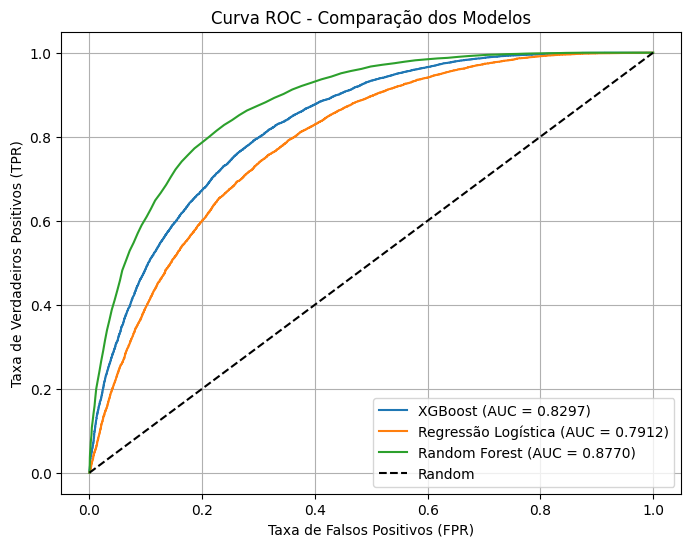

In [8]:
# --- Curva ROC ---
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_probs)
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_probs)
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_probs)
auc_xgb = auc(fpr_xgb, tpr_xgb)
auc_lr = auc(fpr_lr, tpr_lr)
auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(8,6))
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.4f})')
plt.plot(fpr_lr, tpr_lr, label=f'Regressão Logística (AUC = {auc_lr:.4f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC - Comparação dos Modelos')
plt.legend()
plt.grid(True)
plt.show()